In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark Session
spark = (SparkSession.builder
         .appName("Victim Ejection Analysis")
         .config("spark.executor.memory", "4g")
         .config("spark.executor.cores", "2")
         .config("spark.driver.memory", "4g")
         .getOrCreate())

# Load cleaned data
collision_df = spark.read.csv("clean_collision_records.csv", header=True, inferSchema=True)
victim_df = spark.read.csv("clean_victim_records.csv", header=True, inferSchema=True)

collision_df.show(5)
victim_df.show(5)



24/12/19 00:40:48 WARN Utils: Your hostname, Victors-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.68.65 instead (on interface en0)
24/12/19 00:40:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/19 00:40:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/19 00:41:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|           CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|REPORTING_DISTRICT|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|     PRIMARY_RD|   SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|
+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|100010101011401155|         2001| 20010416| 0100|      20010101|           114|      1155|                 0|          1|         4|          198|        0|            0|      DUBLIN BL|    SCARLETT CT|     267|        W|           N|
|100010103174503131|         2001| 20010416| 0100|      

In [2]:
# Join collision and victim data on CASE_ID
combined_df = collision_df.join(victim_df, "CASE_ID", "inner")

# Target Variable: VICTIM_EJECTED (binary: 0 - Not Ejected, 1 - Fully/Partially Ejected)
combined_df = combined_df.withColumn(
    "VICTIM_EJECTED_BINARY",
    when(col("VICTIM_EJECTED").isin(1, 2), 1).otherwise(0)
)

# Drop unused or null-heavy rows
cols_to_drop = ['REPORTING_DISTRICT']
combined_df = combined_df.drop(*cols_to_drop).dropna()

24/12/19 00:41:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


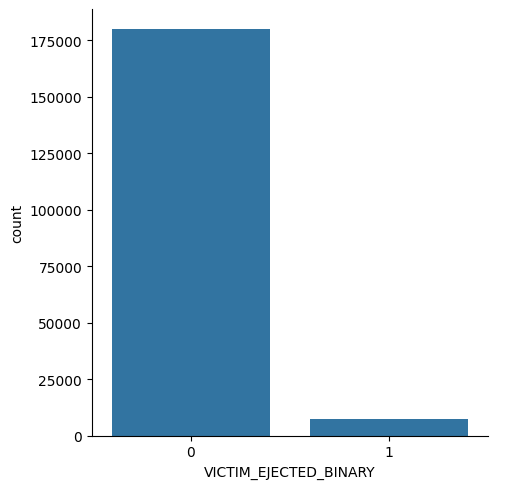

In [3]:
import seaborn as sns

sample_df = combined_df.sample(fraction=0.01, seed=6198)

sns.catplot(x="VICTIM_EJECTED_BINARY", kind="count", data=sample_df.toPandas())

In [4]:

# Features List
categorical_columns = ["VICTIM_SEATING_POSITION", "VICTIM_SAFETY_EQUIP1", "VICTIM_SAFETY_EQUIP2", "CHP_BEAT_TYPE", "VICTIM_SEX"]

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') for col in categorical_columns]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_columns]

# Combine categorical and numerical features
assembler = VectorAssembler(
    inputCols=[col + "_vec" for col in categorical_columns],
    outputCol="features"
)

# Pipeline for encoding
pipeline = Pipeline(stages=indexers + encoders + [assembler])

encoded_df = pipeline.fit(combined_df).transform(combined_df)
encoded_df.printSchema()


# Show results
encoded_df.select("features", "VICTIM_EJECTED_BINARY").show(5, truncate=False)


root
 |-- CASE_ID: decimal(20,0) (nullable = true)
 |-- ACCIDENT_YEAR: integer (nullable = true)
 |-- PROC_DATE: integer (nullable = true)
 |-- JURIS: string (nullable = true)
 |-- COLLISION_DATE: integer (nullable = true)
 |-- COLLISION_TIME: integer (nullable = true)
 |-- OFFICER_ID: string (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- POPULATION: integer (nullable = true)
 |-- CNTY_CITY_LOC: integer (nullable = true)
 |-- BEAT_TYPE: integer (nullable = true)
 |-- CHP_BEAT_TYPE: string (nullable = true)
 |-- PRIMARY_RD: string (nullable = true)
 |-- SECONDARY_RD: string (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- DIRECTION: string (nullable = true)
 |-- INTERSECTION: string (nullable = true)
 |-- PARTY_NUMBER: integer (nullable = true)
 |-- VICTIM_ROLE: string (nullable = true)
 |-- VICTIM_SEX: string (nullable = true)
 |-- VICTIM_AGE: integer (nullable = true)
 |-- VICTIM_DEGREE_OF_INJURY: string (nullable = true)
 |-- VICTIM_SEATING_POSITION

+------------------------------------------+---------------------+
|features                                  |VICTIM_EJECTED_BINARY|
+------------------------------------------+---------------------+
|(90,[1,30,49,74,84],[1.0,1.0,1.0,1.0,1.0])|0                    |
|(90,[2,30,49,74,84],[1.0,1.0,1.0,1.0,1.0])|0                    |
|(90,[0,20,49,74,84],[1.0,1.0,1.0,1.0,1.0])|0                    |
|(90,[1,20,49,74,84],[1.0,1.0,1.0,1.0,1.0])|0                    |
|(90,[1,30,49,74,84],[1.0,1.0,1.0,1.0,1.0])|0                    |
+------------------------------------------+---------------------+
only showing top 5 rows



In [5]:
from pyspark.sql.functions import col, lit, when

# Use encoded_df from previou section
print(f"Columns in encoded_df: {encoded_df.columns}")

# Check for class imbalance
total_count = encoded_df.count()
class_1_count = encoded_df.filter(col("VICTIM_EJECTED_BINARY") == 1).count()
class_0_count = encoded_df.filter(col("VICTIM_EJECTED_BINARY") == 0).count()

print(f"Class 1 Count (Ejected): {class_1_count}")
print(f"Class 0 Count (Not Ejected): {class_0_count}")
print(f"Total Count: {total_count}")

# Calculate weights if imbalance exists
if class_1_count and class_0_count and abs(class_1_count - class_0_count) > 0.1 * total_count:
    weight_1 = total_count / (2 * class_1_count)
    weight_0 = total_count / (2 * class_0_count)

    encoded_df = encoded_df.withColumn(
        "weight",
        when(col("VICTIM_EJECTED_BINARY") == 1, lit(weight_1)).otherwise(lit(weight_0))
    )
    print(f"Weight for Class 1 (Minority): {weight_1}")
    print(f"Weight for Class 0 (Majority): {weight_0}")
else:
    print("No significant imbalance detected; skipping weights.")

# Assemble features using columns generated in Section 3
assembled_df = encoded_df.select('features', 'VICTIM_EJECTED_BINARY', 'weight')

# Split the data into training and test sets
train_df, test_df = assembled_df.randomSplit([0.7, 0.3], seed=7122)

# Train a Logistic Regression model
log_reg = LogisticRegression(featuresCol="features", labelCol="VICTIM_EJECTED_BINARY", weightCol="weight")
log_reg_model = log_reg.fit(train_df)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="VICTIM_EJECTED_BINARY", metricName="areaUnderROC")
predictions = log_reg_model.transform(test_df)

# Print evaluation metrics
auc = evaluator.evaluate(predictions)
print(f"AUC Score: {auc}")

# Inspect predictions
predictions.select("VICTIM_EJECTED_BINARY", "prediction", "probability").show(5, truncate=False)

# Print model summary for debugging
summary = log_reg_model.summary
summary.predictions.show(5)
summary.predictions.describe().show()


Columns in encoded_df: ['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE', 'COLLISION_TIME', 'OFFICER_ID', 'DAY_OF_WEEK', 'POPULATION', 'CNTY_CITY_LOC', 'BEAT_TYPE', 'CHP_BEAT_TYPE', 'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION', 'PARTY_NUMBER', 'VICTIM_ROLE', 'VICTIM_SEX', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY', 'VICTIM_SEATING_POSITION', 'VICTIM_SAFETY_EQUIP1', 'VICTIM_SAFETY_EQUIP2', 'VICTIM_EJECTED', 'VICTIM_EJECTED_BINARY', 'VICTIM_SEATING_POSITION_index', 'VICTIM_SAFETY_EQUIP1_index', 'VICTIM_SAFETY_EQUIP2_index', 'CHP_BEAT_TYPE_index', 'VICTIM_SEX_index', 'VICTIM_SEATING_POSITION_vec', 'VICTIM_SAFETY_EQUIP1_vec', 'VICTIM_SAFETY_EQUIP2_vec', 'CHP_BEAT_TYPE_vec', 'VICTIM_SEX_vec', 'features']


Class 1 Count (Ejected): 754554
Class 0 Count (Not Ejected): 17956059
Total Count: 18710613
Weight for Class 1 (Minority): 12.39845855962595
Weight for Class 0 (Majority): 0.5210111249912912


24/12/19 00:46:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/19 00:46:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC Score: 0.9690579799227573


+---------------------+----------+----------------------------------------+
|VICTIM_EJECTED_BINARY|prediction|probability                             |
+---------------------+----------+----------------------------------------+
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
+---------------------+----------+----------------------------------------+
only showing top 5 rows



+--------------------+---------------------+------------------+--------------------+--------------------+----------+
|            features|VICTIM_EJECTED_BINARY|            weight|       rawPrediction|         probability|prediction|
+--------------------+---------------------+------------------+--------------------+--------------------+----------+
|(90,[0,19,48,74,8...|                  0.0|0.5210111249912912|[3.64200136858361...|[0.97446905128631...|       0.0|
|(90,[0,19,48,74,8...|                  0.0|0.5210111249912912|[3.64200136858361...|[0.97446905128631...|       0.0|
|(90,[0,19,48,74,8...|                  0.0|0.5210111249912912|[3.64200136858361...|[0.97446905128631...|       0.0|
|(90,[0,19,48,74,8...|                  0.0|0.5210111249912912|[3.64200136858361...|[0.97446905128631...|       0.0|
|(90,[0,19,48,74,8...|                  0.0|0.5210111249912912|[3.64200136858361...|[0.97446905128631...|       0.0|
+--------------------+---------------------+------------------+-

+-------+---------------------+------------------+-------------------+
|summary|VICTIM_EJECTED_BINARY|            weight|         prediction|
+-------+---------------------+------------------+-------------------+
|  count|             13100117|          13100117|           13100117|
|   mean|   0.0403388763627073|1.0001340085715253|0.11187358097641419|
| stddev|  0.19675277474933583|  2.33692073970377| 0.3152108666280904|
|    min|                  0.0|0.5210111249912912|                0.0|
|    max|                  1.0| 12.39845855962595|                1.0|
+-------+---------------------+------------------+-------------------+



In [6]:
# Print AUC Score
print(f"AUC Score: {auc}")

# Inspect predictions
predictions.select("VICTIM_EJECTED_BINARY", "prediction", "probability").show(10, truncate=False)

# Check encoded features (only if debugging encoding)
print("Feature Columns Vectorized:")
for col_name in categorical_columns:
    print(f"  - {col_name}_index -> {col_name}_vec")


AUC Score: 0.9690579799227573


+---------------------+----------+----------------------------------------+
|VICTIM_EJECTED_BINARY|prediction|probability                             |
+---------------------+----------+----------------------------------------+
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
|0                    |0.0       |[0.9744690512863117,0.02553094871368833]|
+-----------

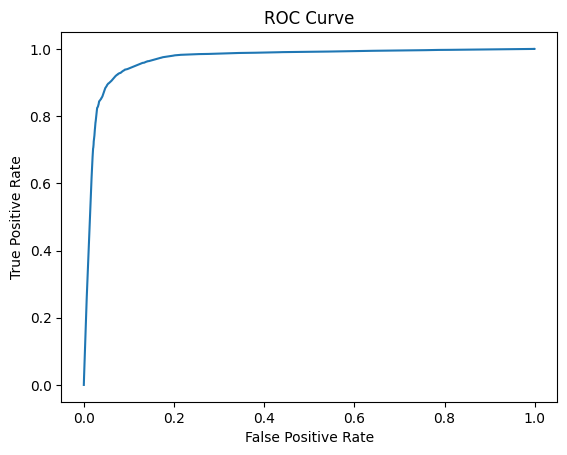

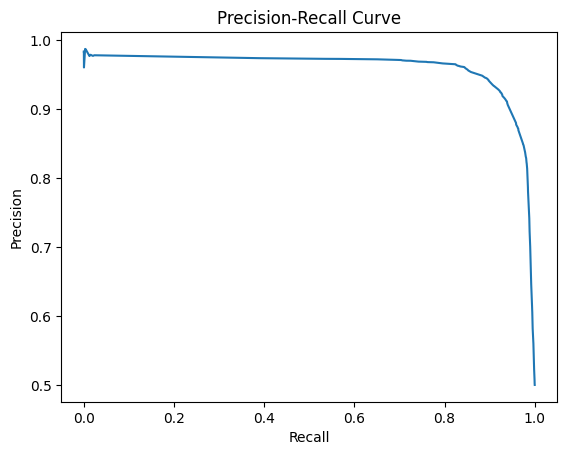

[0.9262398820415275, 0.9227170253364724]
[0.922371747977462, 0.9265693242803114]


In [7]:
import matplotlib.pyplot as plt 

roc = summary.roc.toPandas()

plt.plot(roc["FPR"], roc["TPR"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

precision = summary.pr.toPandas()
plt.plot(precision["recall"], precision["precision"])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

print(summary.precisionByLabel)
print(summary.recallByLabel)